# Data Exploration

### TODO

- sort out useful and useless files
- create an importable package for utils functions

In [1]:
# %%
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from captum.attr import Saliency
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd

/home/laura/aimir/embeddings_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_embeddings(real_files, ai_files):
    X = []
    y = []

    for file in ai_files:
        if file.endswith('.npy'):
            embedding = np.load(file)
            if len(embedding.shape) == 2:
                embedding = np.concatenate((np.mean(embedding, axis=0), np.var(embedding, axis=0)))
            X.append(embedding)
            y.append(1) # AI generated
    
    for file in real_files:
        if file.endswith('.npy'):
            embedding = np.load(file)
            if len(embedding.shape) == 2:
                embedding = np.concatenate((np.mean(embedding, axis=0), np.var(embedding, axis=0))) 
            X.append(embedding)
            y.append(0) # Real

    return np.array(X), np.array(y)

def get_split(split, embedding, real_folder, ai_folders):
    ai_files = {}
    with open(f'/home/laura/aimir/{real_folder}/{split}.txt', 'r') as f:
        real_files = f.read().splitlines()
    for folder in ai_folders:
        with open(f'/home/laura/aimir/{folder}/{split}.txt', 'r') as f:
            ai_files[folder] = f.read().splitlines()
    
    real_files = [f'/home/laura/aimir/{real_folder}/audio/embeddings/{embedding}/{file}.npy' for file in real_files]
    ai_files = [f'/home/laura/aimir/{folder}/audio/embeddings/{embedding}/{file}.npy' for folder in ai_folders for file in ai_files[folder]]

    X, y = load_embeddings(real_files, ai_files)
    return X, y

def get_metadata(split, real_folder, ai_folders):
    metadata_all = []

    ai_files = {}
    with open(f'/home/laura/aimir/{real_folder}/{split}.txt', 'r') as f:
        real_files = f.read().splitlines()
    for folder in ai_folders:
        with open(f'/home/laura/aimir/{folder}/{split}.txt', 'r') as f:
            ai_files[folder] = f.read().splitlines()
    
    real_files = [f'/home/laura/aimir/{real_folder}/metadata/{file}.json' for file in real_files]
    ai_files = [f'/home/laura/aimir/{folder}/metadata/{file}.json' for folder in ai_folders for file in ai_files[folder]]

    for file in real_files:
        with open(file, 'r') as f:
            metadata = json.load(f)
            metadata['file'] = file
            metadata_all.append(metadata)
    for file in ai_files:
        with open(file, 'r') as f:
            metadata = json.load(f)
            metadata['file'] = file
            metadata_all.append(metadata)

    # return as a dataframe
    metadata_all = pd.DataFrame(metadata_all)
    return metadata_all



In [3]:
real_folder = 'lastfm'
ai_folders = ['suno', 'udio']
embedding = 'clap-laion-music'

X_train, y_train = get_split('sample', embedding, real_folder, ai_folders)
print(X_train.shape, y_train.shape)

(150, 512) (150,)


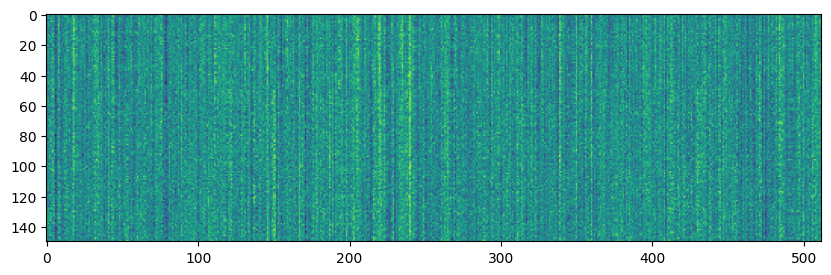

In [4]:
# plot a sample of X_train
plt.figure(figsize=(10, 10))
plt.imshow(X_train)
plt.show()

In [5]:
metadata_train = get_metadata('train', real_folder, ai_folders)
metadata_train.head()

,id_dataset,id_spotify,url_spotify_preview,url_lastfm,artist,name,youtube_url,tags,duration,file,...,disliked,parent_id,search_text,optimized_prompt,d\nisliked,query_similarity,error_code,publishable,artist_image,audio_conditioning_type
0,4b47552251ce2e42eb98f7269a128b9b,0gNsJmoxAkJG2V6nIwMEGT,https://p.scdn.co/mp3-preview/c103ab78ed215268...,https://www.last.fm/music/Nick+Drake/_/Horn,Nick Drake,Horn,https://www.youtube.com/watch?v=9absJQoPCX8,"[mellow, acoustic, folk, singer-songwriter, in...",81.892993,/home/laura/aimir/lastfm/metadata/4b47552251ce...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2209187dc5701bf6980aed01735779b1,1ac1N8yGLZ5FzxruWxJeaR,https://p.scdn.co/mp3-preview/d99c43d7ac1861e8...,https://www.last.fm/music/Ewun/_/The+Divide,Ewun,The Divide,https://www.youtube.com/watch?v=mRCyDw594eo,"[darkstep, drum and bass]",521.220998,/home/laura/aimir/lastfm/metadata/2209187dc570...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,148fdcec15f08eefa33bb16d4dd44611,3vFxl7JdVpMXbNn38DYHxy,https://p.scdn.co/mp3-preview/4c7b6c4bf61355da...,https://www.last.fm/music/Ulver/_/Preface,Ulver,Preface,https://www.youtube.com/watch?v=O4Mz0VpNhkg,"[electronic, soundtrack, ambient, avant-garde]",102.008005,/home/laura/aimir/lastfm/metadata/148fdcec15f0...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,04a6101abfa779ac46b83475f4d75cee,0AJ2MI49ypVFYsLcNKKZCa,https://p.scdn.co/mp3-preview/8228a565690460c2...,https://www.last.fm/music/The+Rolling+Stones/_...,The Rolling Stones,My Girl,https://www.youtube.com/watch?v=0YxVIi1yzX4,"[the rolling stones, rock, cover, 60s, classic...",158.170998,/home/laura/aimir/lastfm/metadata/04a6101abfa7...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35b6a0b203e93b100e6cce6f66cffa1e,0Cw4icqLedVj8GFvQvEqUN,https://p.scdn.co/mp3-preview/e79912d2fa34c8e9...,https://www.last.fm/music/Creedence+Clearwater...,Creedence Clearwater Revival,Green River,https://www.youtube.com/watch?v=L5V9nK7-OkM,"[60s, classic rock, rock, blues rock, southern...",156.029002,/home/laura/aimir/lastfm/metadata/35b6a0b203e9...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
metadata_val = get_metadata('val', real_folder, ai_folders)
metadata_test = get_metadata('test', real_folder, ai_folders)

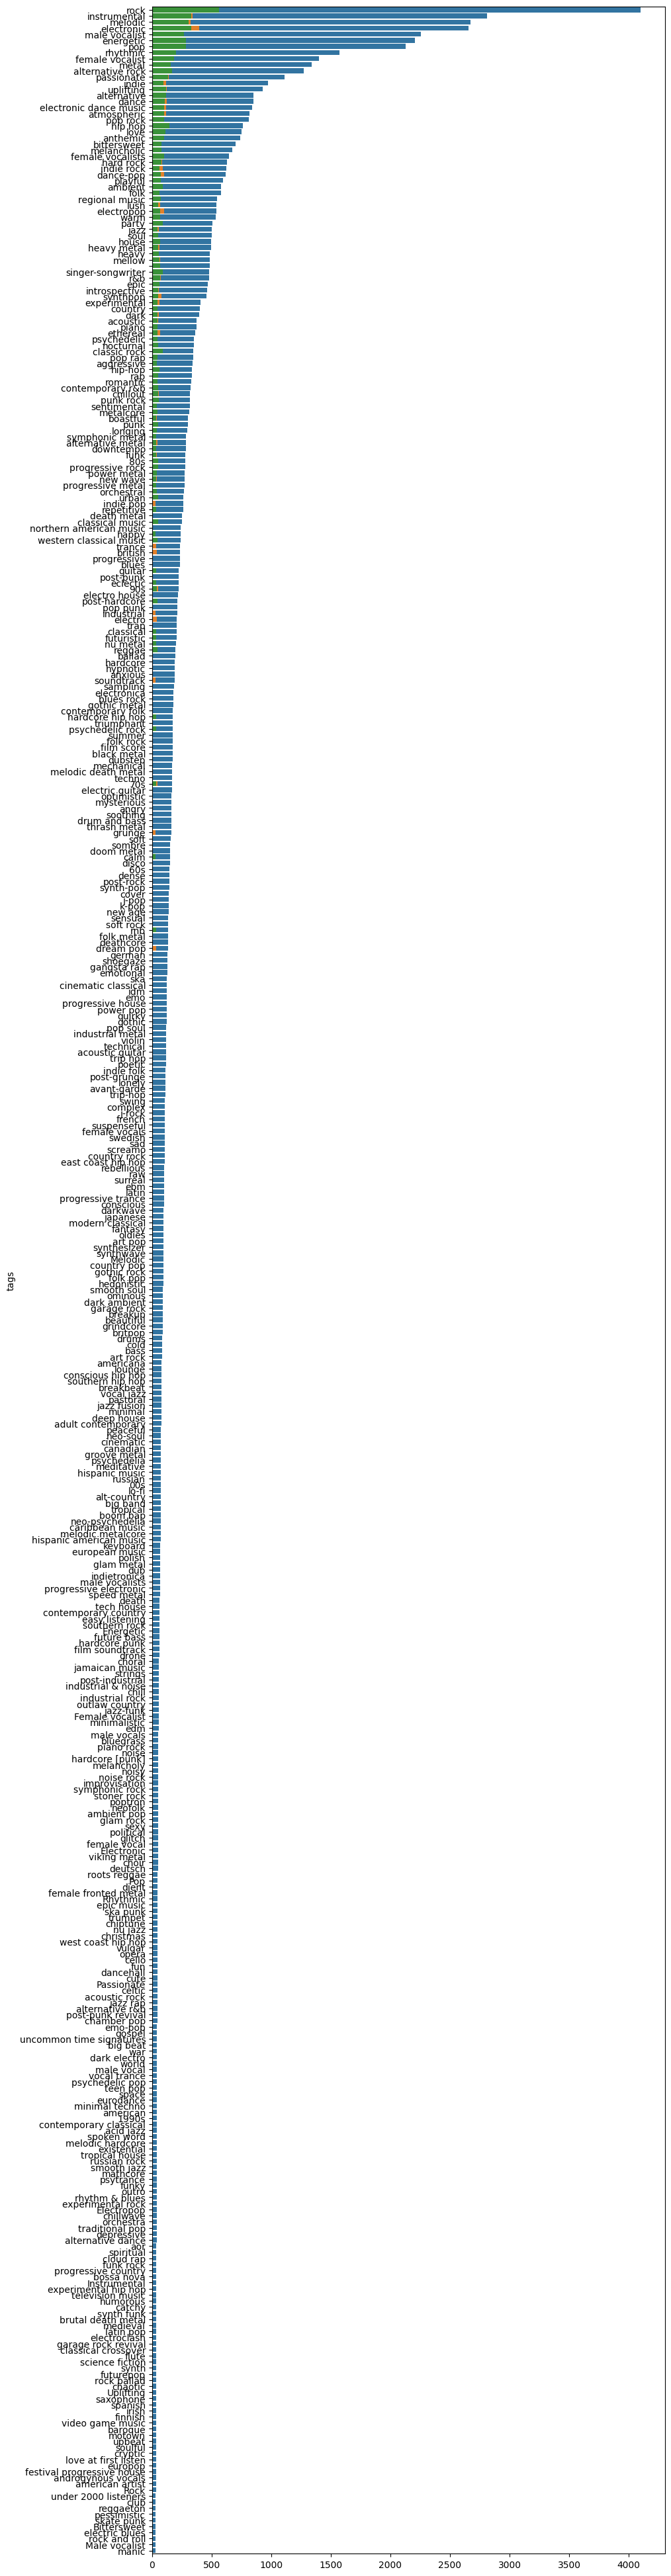

In [32]:
# histogram of the tags
tags_train = metadata_train['tags'].explode().value_counts()
# for the plot, only use tags that have more than 30 occurrences
tags_plot = tags_train[tags_train > 30]
plt.figure(figsize=(10, 50))
sns.barplot(x=tags_plot.values, y=tags_plot.index)

# do the same for the val and test sets
tags_val = metadata_val['tags'].explode().value_counts()
tags_test = metadata_test['tags'].explode().value_counts()

sns.barplot(x=tags_val[tags_val > 30].values, y=tags_val[tags_val > 30].index)
sns.barplot(x=tags_test[tags_test > 30].values, y=tags_test[tags_test > 30].index)
plt.show()

In [9]:
tags

tags
rock                                                             4100
instrumental                                                     2809
melodic                                                          2675
electronic                                                       2657
male vocalist                                                    2257
                                                                 ... 
rhythmic lively marching band                                       1
Heavy metal style, electric guitar solo, 150 beats per minute       1
classical orchestral edm                                            1
Techno, hits, bajos                                                 1
hard trap                                                           1
Name: count, Length: 15665, dtype: int64

43f632f1-30b5-4598-b980-abd6ef426be4
3859      No
27471     No
58631     No
72686     No
95128     No
117915    No
140769    No
189601    No
202832    No
229010    No
261571    No
294950    No
328716    No
380571    No
396828    No
433119    No
470395    No
508738    No
562195    No
589531    No
Name: error_play, dtype: object


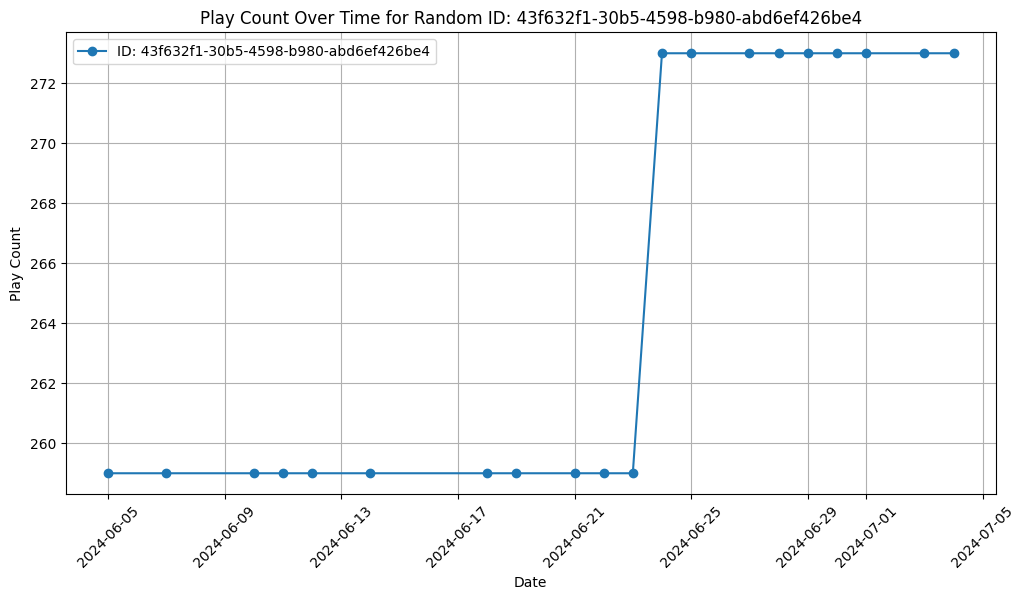

a5e2198a-f352-4abb-9a24-7f81b143ded3


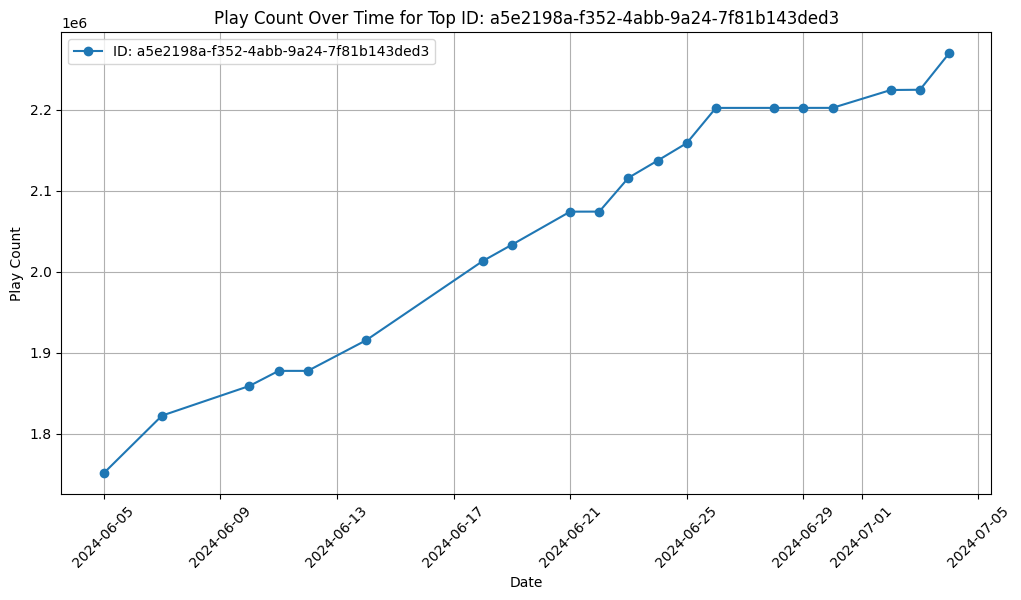

In [33]:
# Path to the folder containing the CSV files
folder_path = '/home/laura/aimir/suno_likes'

# Initialize an empty list to store the dataframes
dfs = []

# Load all CSV files into a single DataFrame
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

# Concatenate all dataframes
data = pd.concat(dfs, ignore_index=True)

# Convert 'time' column to datetime format and keep only the date
data['date'] = pd.to_datetime(data['time'], unit='s').dt.date

# Drop the original 'time' column
data = data.drop(columns=['time'])

# Sort data by date
data = data.sort_values(by='date')

# Pick a random id
random_id = np.random.choice(data['id'].unique())

# Find the id with the highest play_count over time
id_play_counts = data.groupby('id')['play_count'].sum()
top_id = id_play_counts.idxmax()

# Plot play_count over time for the random id
random_id_data = data[data['id'] == random_id]
random_id_data = random_id_data.groupby('date')['play_count'].sum().reset_index()

print(random_id)
# print the values of error_play,error_upvote of that random id
print(data[data['id'] == random_id]['error_play'])
plt.figure(figsize=(12, 6))
plt.plot(random_id_data['date'], random_id_data['play_count'], marker='o', label=f'ID: {random_id}')
plt.title(f'Play Count Over Time for Random ID: {random_id}')
plt.xlabel('Date')
plt.ylabel('Play Count')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot play_count over time for the id with the most play_count
top_id_data = data[data['id'] == top_id]
top_id_data = top_id_data.groupby('date')['play_count'].sum().reset_index()

print(top_id)
plt.figure(figsize=(12, 6))
plt.plot(top_id_data['date'], top_id_data['play_count'], marker='o', label=f'ID: {top_id}')
plt.title(f'Play Count Over Time for Top ID: {top_id}')
plt.xlabel('Date')
plt.ylabel('Play Count')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()